# Eclipsing binary: Solving for *everything* the slow way

In this notebook, we're continuing our tutorial on how to do inference. In [this notebook](EclipsingBinary_Generate.ipynb) we showed how to use `pymc3` to get posteriors over map coefficients of an eclipsing binary light curve, and in [this notebook](EclipsingBinary_Linear.ipynb) we did the same thing using the analytic linear formalism of `starry`.

Here, we are going to solve for *everything*: the map coefficients and all the orbital parameters of the system. Note that this is an expensive problem to solve (typically several hours on a laptop) since we need to sample in la very high dimensional and somewhat complex space. In this notebook, we use `pymc3` to sample in all the parameters, *including* the map coefficients. **This is therefore the slow way of doing this.** As we will see in the [next notebook](EclipsingBinary_FullSolution.ipynb), we can take advantage of the best of both worlds: sample the non-linear orbital parameters while analytically marginalizing over the map coefficients. Here, however, we'll solve the full problem using `pymc3` for comparison later.

**Note that since we're using pymc3, we need to enable lazy evaluation mode in starry.**

In [1]:
%matplotlib inline

In [2]:
%run notebook_setup.py

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import exoplanet as xo
import os
import starry
from corner import corner
import theano.tensor as tt
from tqdm.notebook import tqdm

np.random.seed(12)
starry.config.lazy = True
starry.config.quiet = True

## Load the data

Let's load the EB dataset:

In [4]:
# Run the Generate notebook if needed
if not os.path.exists("eb.npz"):
    import nbformat
    from nbconvert.preprocessors import ExecutePreprocessor

    with open("EclipsingBinary_Generate.ipynb") as f:
        nb = nbformat.read(f, as_version=4)
    ep = ExecutePreprocessor(timeout=600, kernel_name="python3")
    ep.preprocess(nb);

In [5]:
data = np.load("eb.npz", allow_pickle=True)
A = data["A"].item()
B = data["B"].item()
t = data["t"]
flux = data["flux"]
sigma = data["sigma"]

Here's the light curve we're going to do inference on:

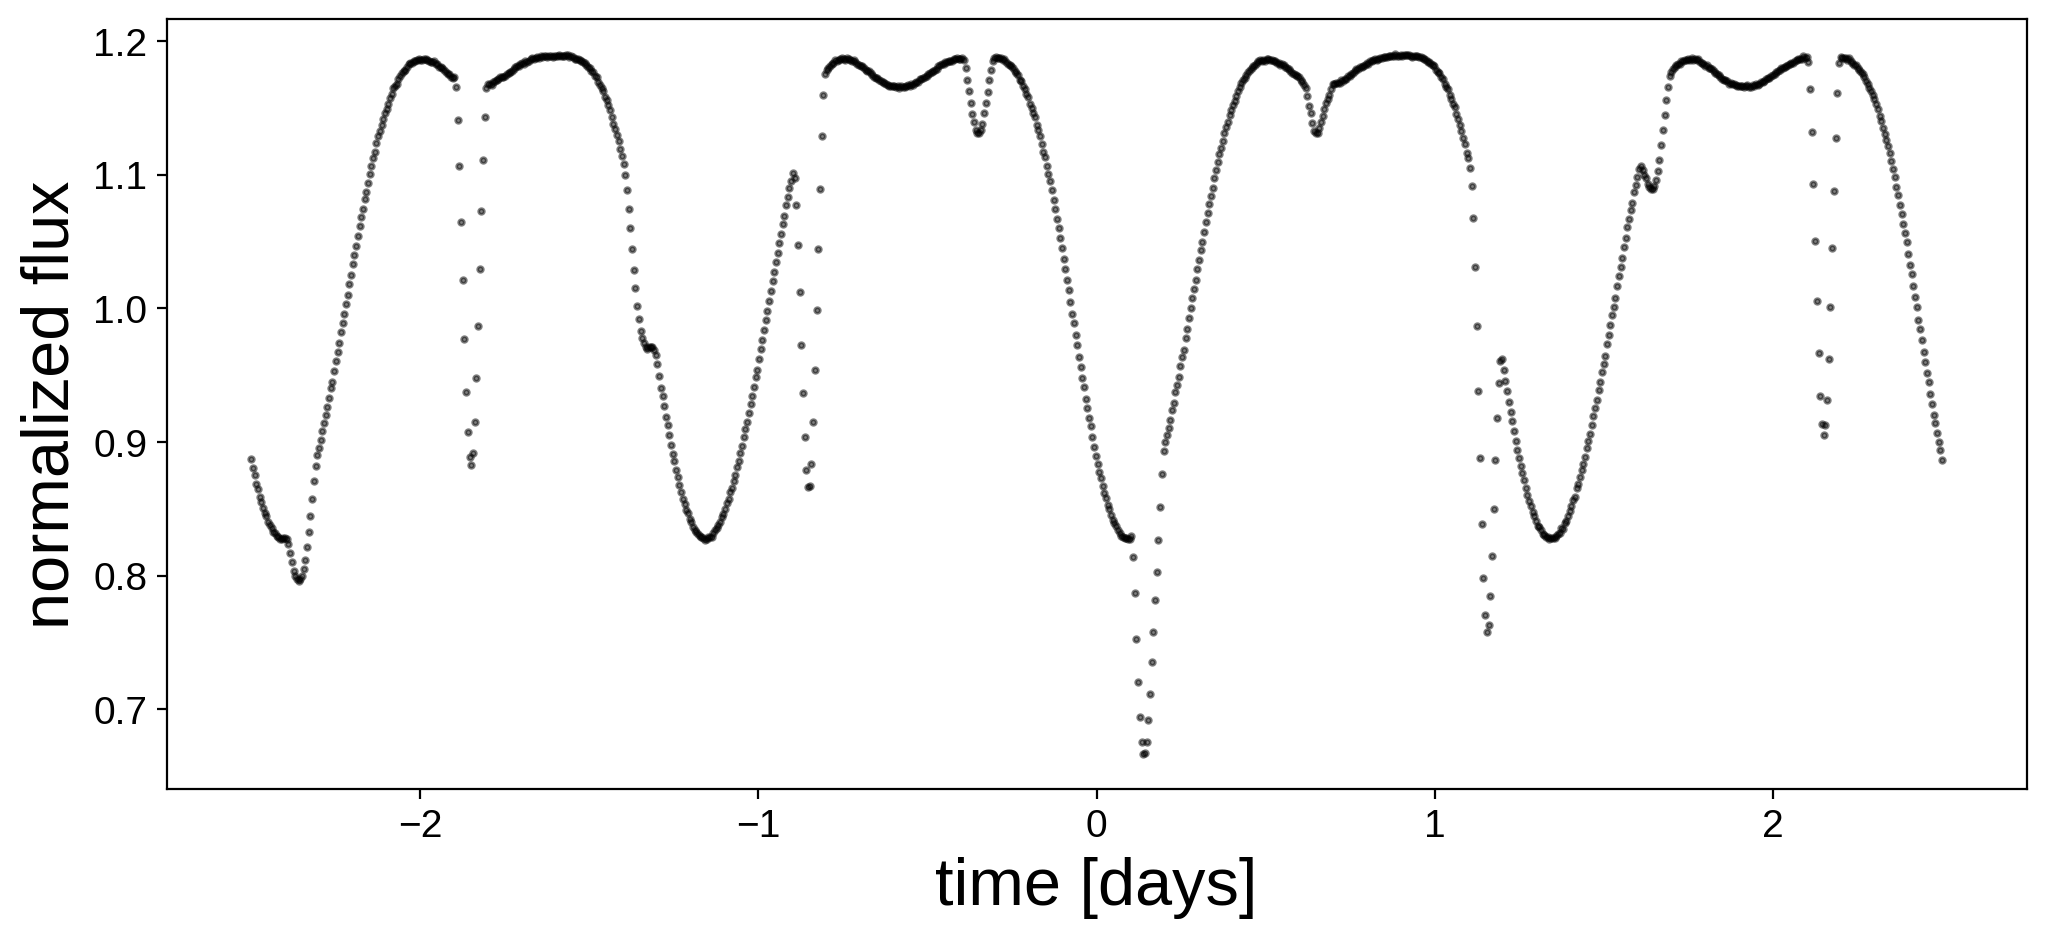

In [6]:
fig, ax = plt.subplots(1, figsize=(12, 5))
ax.plot(t, flux, "k.", alpha=0.5, ms=4)
ax.set_xlabel("time [days]", fontsize=24)
ax.set_ylabel("normalized flux", fontsize=24);

We now instantiate the primary, secondary, and system objects within a `pm.Model()` context.
Here are the priors we are going to assume for the parameters of the primary:

| Parameter      | True Value | Assumed Value / Prior     | Units          |
| ---            | ---        | ---                       | ---            |
|$\mathrm{amp}$  | $1.0$      | $\mathcal{N}(1.0,0.1^2)$  | $-$            |
|$r$             | $1.0$      | $\mathcal{N}(0.95,0.1^2)$ | $R_\odot$      |
|$m$             | $1.0$      | $\mathcal{N}(1.05,0.1^2)$ | $M_\odot$      |
|$P_\mathrm{rot}$| $1.25$     | $\mathcal{N}(1.25,0.01^2)$| $\mathrm{days}$|
|$i$             | $80.0$     | $\mathcal{N}(80.0,5.0^2)$ | $\mathrm{deg}$ |
|$u_1$           | $0.40$     | $0.40$                    | $-$            |
|$u_2$           | $0.25$     | $0.25$                    | $-$            |

And here are the priors we are going to assume for the secondary:

| Parameter      | True Value | Assumed Value / Prior      | Units          |
| ---            | ---        | ---                        | ---            |
|$\mathrm{amp}$  | $0.1$      | $\mathcal{N}(0.1,0.01^2)$  | $-$            |
|$r$             | $0.7$      | $\mathcal{N}(0.75,0.1^2)$  | $R_\odot$      |
|$m$             | $0.7$      | $\mathcal{N}(0.70,0.1^2)$  | $M_\odot$      |
|$P_\mathrm{rot}$| $0.625$    | $\mathcal{N}(0.625,0.01^2)$| $\mathrm{days}$|
|$P_\mathrm{orb}$| $1.0$      | $\mathcal{N}(1.01,0.01^2)$ | $\mathrm{days}$|
|$t_0$           | $0.15$     | $\mathcal{N}(0.15,0.001^2)$| $\mathrm{days}$|
|$i$             | $80.0$     | $\mathcal{N}(80.0,5.0^2)$  | $\mathrm{deg}$ |
|$e$             | $0.0$      | $0.0$                      | $-$            |
|$\Omega$        | $0.0$      | $0.0$                      | $\mathrm{deg}$ |
|$u_1$           | $0.20$     | $0.20$                     | $-$            |
|$u_2$           | $0.05$     | $0.05$                     | $-$            |

Above, $\mathcal{N}$ denotes a 1-d normal prior with a given mean and variance. Note that for simplicity we are **fixing** the limb darkening coefficients at their true value.

As in the previous notebooks, we'll assume a gaussian priors for both sets of spherical harmonic coefficients.

In [7]:
with pm.Model() as model:

    # Some of the gaussians have significant support at < 0
    # Let's force them to be positive (required for quantites
    # such as radius, mass, etc.)
    # NOTE: When using `pm.Bound`, it is *very important* to
    # explicitly define a `testval` -- otherwise this defaults
    # to unity. Since the `testval` is used to initialize the
    # optimization step, it's very important we start at
    # reasonable values, otherwise things will never converge!
    PositiveNormal = pm.Bound(pm.Normal, lower=0.0)

    # Primary
    A_inc = pm.Normal("A_inc", mu=80, sd=5, testval=80)
    A_amp = pm.Normal("A_amp", mu=1.0, sd=0.1, testval=1.0)
    A_r = PositiveNormal("A_r", mu=0.95, sd=0.1, testval=0.95)
    A_m = PositiveNormal("A_m", mu=1.05, sd=0.1, testval=1.05)
    A_prot = PositiveNormal("A_prot", mu=1.25, sd=0.01, testval=1.25)
    pri = starry.Primary(
        starry.Map(ydeg=A["ydeg"], udeg=A["udeg"], inc=A_inc, amp=A_amp),
        r=A_r,
        m=A_m,
        prot=A_prot,
    )
    pri.map[1] = A["u"][0]
    pri.map[2] = A["u"][1]

    # The Ylm coefficients of the primary
    # with a zero-mean isotropic Gaussian prior
    ncoeff = pri.map.Ny - 1
    pri_mu = np.zeros(ncoeff)
    pri_cov = 1e-2 * np.eye(ncoeff)
    pri.map[1:, :] = pm.MvNormal("pri_y", pri_mu, pri_cov, shape=(ncoeff,))

    # Secondary
    B_inc = pm.Normal("B_inc", mu=80, sd=5, testval=80)
    B_amp = pm.Normal("B_amp", mu=0.1, sd=0.01, testval=0.1)
    B_r = PositiveNormal("B_r", mu=0.75, sd=0.1, testval=0.75)
    B_m = PositiveNormal("B_m", mu=0.70, sd=0.1, testval=0.70)
    B_prot = PositiveNormal("B_prot", mu=0.625, sd=0.01, testval=0.625)
    B_porb = PositiveNormal("B_porb", mu=1.01, sd=0.01, testval=1.01)
    B_t0 = pm.Normal("B_t0", mu=0.15, sd=0.001, testval=0.15)
    sec = starry.Secondary(
        starry.Map(ydeg=B["ydeg"], udeg=B["udeg"], inc=B_inc, amp=B_amp),
        r=B_r,
        m=B_m,
        porb=B_porb,
        prot=B_prot,
        t0=B_t0,
        inc=B_inc,
    )
    sec.map[1] = B["u"][0]
    sec.map[2] = B["u"][1]

    # The Ylm coefficients of the secondary
    # with a zero-mean isotropic Gaussian prior
    ncoeff = sec.map.Ny - 1
    sec_mu = np.zeros(ncoeff)
    sec_cov = 1e-2 * np.eye(ncoeff)
    sec.map[1:, :] = pm.MvNormal("sec_y", sec_mu, sec_cov, shape=(ncoeff,))

    # System
    sys = starry.System(pri, sec)

    # Compute the flux
    flux_model = sys.flux(t=t)

    # Track some values for plotting later
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = xo.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=sigma, observed=flux)

Now that we've specified the model, we run gradient descent to find the best fit solution. This will give us a decent starting point for the inference problem.

**NOTE:** Because we have so many parameters, it's a **bad** idea to try to optimize everything at once. We'll therefore iterate back and forth a few times between optimizing the surface maps and optimizing the orbital parameters.

In [8]:
with model:
    map_soln = xo.optimize(
        vars=[A_inc, A_r, A_m, A_prot, B_inc, B_r, B_m, B_prot, B_porb, B_t0],
        start=model.test_point,
    )

optimizing logp for variables: [B_t0, B_porb, B_prot, B_m, B_r, B_inc, A_prot, A_m, A_r, A_inc]
146it [00:03, 37.08it/s, logp=-3.290297e+07]
message: Desired error not necessarily achieved due to precision loss.
logp: -34272685.68890266 -> -32902974.30527578


In [9]:
with model:
    map_soln = xo.optimize(
        vars=[A_amp, pri.map[1:, :], B_amp, sec.map[1:, :]], start=map_soln
    )

optimizing logp for variables: [sec_y, B_amp, pri_y, A_amp]
837it [00:05, 158.47it/s, logp=3.807872e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: -32902974.30527578 -> 3807.8722091388668


In [10]:
with model:
    map_soln = xo.optimize(
        vars=[A_inc, A_r, A_m, A_prot, B_inc, B_r, B_m, B_prot, B_porb, B_t0],
        start=map_soln,
    )

optimizing logp for variables: [B_t0, B_porb, B_prot, B_m, B_r, B_inc, A_prot, A_m, A_r, A_inc]
109it [00:02, 43.42it/s, logp=4.217677e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 3807.8722091388668 -> 4217.677137360188


In [11]:
with model:
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [sec_y, B_t0, B_porb, B_prot, B_m, B_r, B_amp, B_inc, pri_y, A_prot, A_m, A_r, A_amp, A_inc]
1719it [00:27, 62.65it/s, logp=6.307507e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 4217.677137360188 -> 6307.506745198042


Let's see how we did:

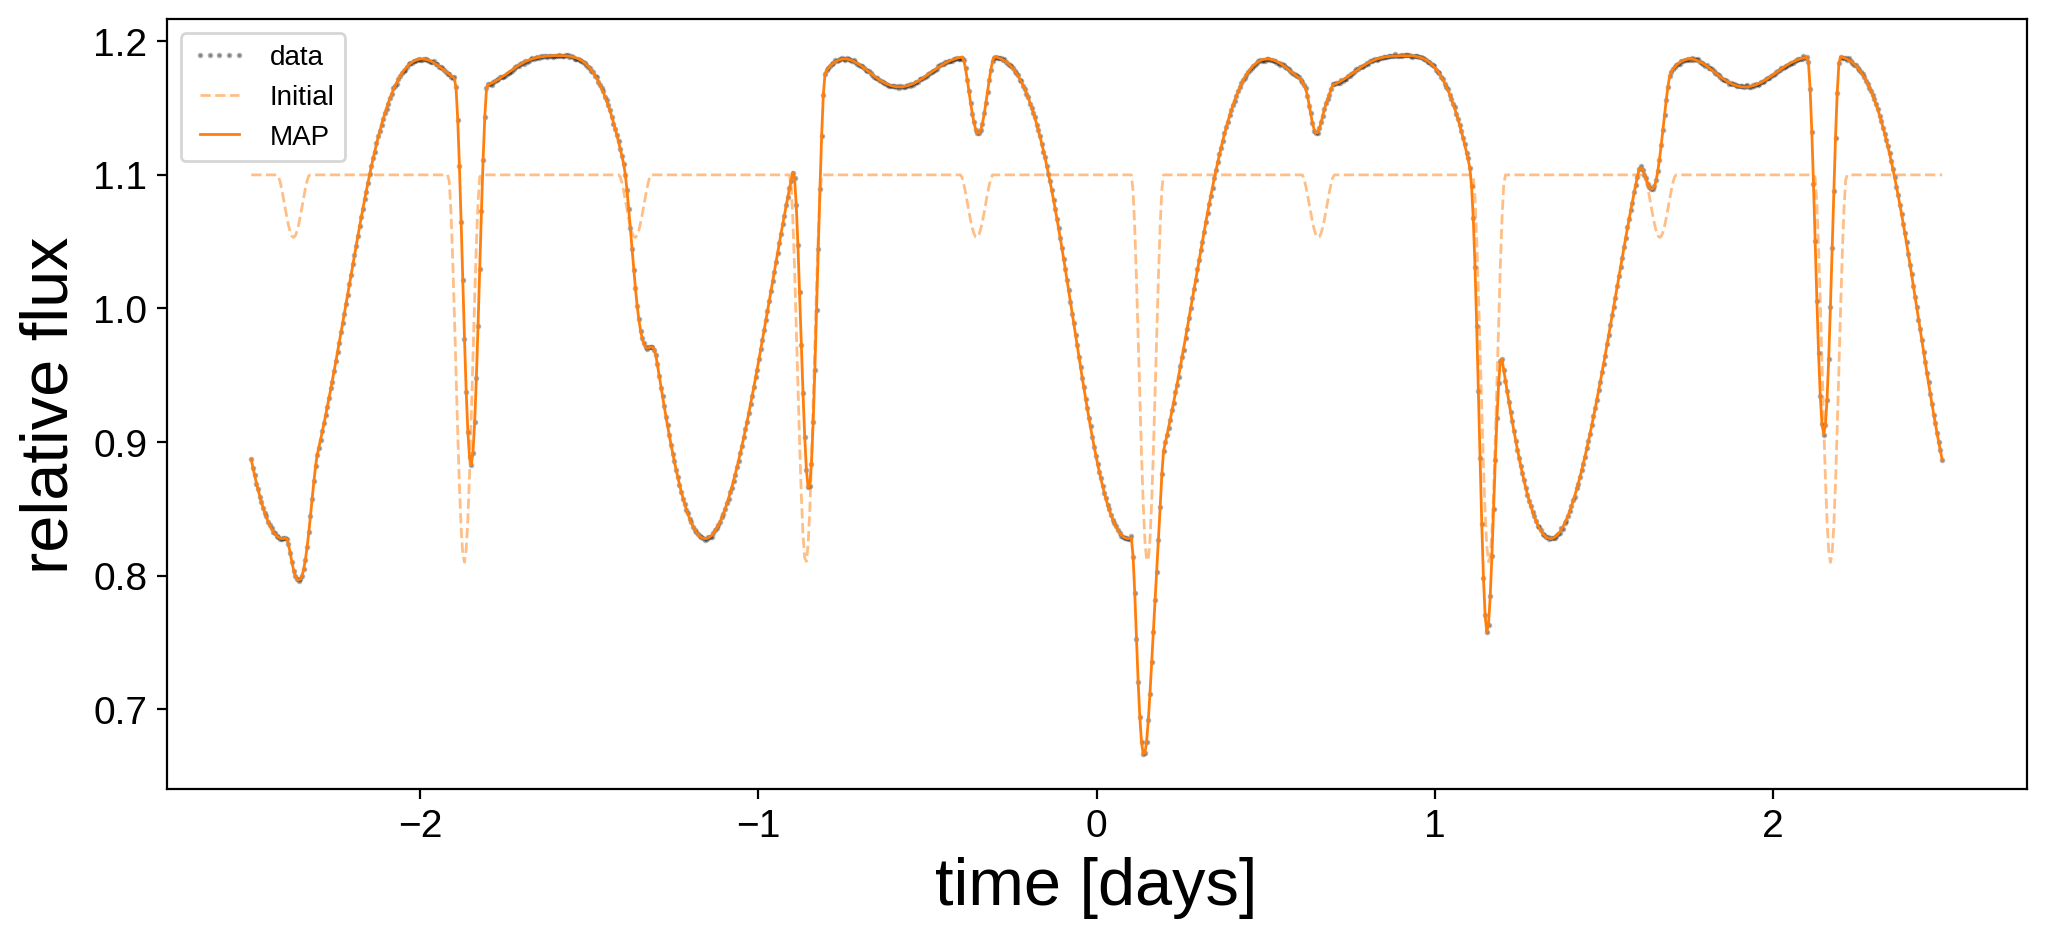

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(t, flux, "k.", alpha=0.3, ms=2, label="data")
plt.plot(t, flux_model_guess, "C1--", lw=1, alpha=0.5, label="Initial")
plt.plot(
    t, xo.eval_in_model(flux_model, map_soln, model=model), "C1-", label="MAP", lw=1
)
plt.legend(fontsize=10, numpoints=5)
plt.xlabel("time [days]", fontsize=24)
plt.ylabel("relative flux", fontsize=24);

Not bad! Here are the best fit surface maps:

In [13]:
map = starry.Map(ydeg=A["ydeg"])
map.inc = map_soln["A_inc"]
map.amp = map_soln["A_amp"]
map[1:, :] = map_soln["pri_y"]
map.show(theta=np.linspace(0, 360, 50))

In [14]:
map = starry.Map(ydeg=B["ydeg"])
map.inc = map_soln["B_inc"]
map.amp = map_soln["B_amp"]
map[1:, :] = map_soln["sec_y"]
map.show(theta=np.linspace(0, 360, 50))

Also pretty good! Now the fun part: sampling. Sit tight -- this will take several hours.

In [15]:
%%time
with model:
    trace = pm.sample(
        tune=2000,
        draws=2500,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sec_y, B_t0, B_porb, B_prot, B_m, B_r, B_amp, B_inc, pri_y, A_prot, A_m, A_r, A_amp, A_inc]
Sampling 4 chains, 308 divergences: 100%|██████████| 18000/18000 [16:27:49<00:00,  3.29s/draws]
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


CPU times: user 4h 15min 40s, sys: 21min 47s, total: 4h 37min 27s
Wall time: 16h 29min 28s


That took **a very long time.** Let's check the diagnostics:

In [16]:
var_names_A = ["A_m", "A_r", "A_prot", "A_inc", "A_amp"]
var_names_B = ["B_m", "B_r", "B_porb", "B_prot", "B_inc", "B_t0", "B_amp"]
display(pm.summary(trace, var_names=var_names_A + var_names_B))

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
A_m      1.045  0.098   0.867    1.234      0.001    0.001    4291.0  4291.0   
A_r      1.025  0.029   0.971    1.080      0.000    0.000    3565.0  3545.0   
A_prot   1.250  0.000   1.250    1.250      0.000    0.000    8705.0  8705.0   
A_inc   81.211  0.601  80.129   82.380      0.019    0.013    1004.0  1004.0   
A_amp    1.004  0.021   0.964    1.045      0.001    0.000    1425.0  1416.0   
B_m      0.701  0.096   0.518    0.876      0.002    0.001    3112.0  3112.0   
B_r      0.686  0.022   0.646    0.727      0.000    0.000    2528.0  2528.0   
B_porb   1.000  0.000   1.000    1.000      0.000    0.000    1843.0  1843.0   
B_prot   0.625  0.000   0.625    0.625      0.000    0.000    7695.0  7695.0   
B_inc   80.037  0.260  79.541   80.496      0.008    0.006    1047.0  1047.0   
B_t0     0.150  0.000   0.150    0.150      0.000    0.000    1671.0  1671.0   
B_amp    0.089  0.006   0.078    0.101      0.000    0.000     777.0   773.0   

        ess_bulk  ess_tail  r_hat  
A_m       4328.0    4468.0   1.00  
A_r       3550.0    5055.0   1.00  
A_prot    8718.0    6825.0   1.00  
A_inc     1008.0    1623.0   1.00  
A_amp     1435.0    2161.0   1.00  
B_m       3105.0    2684.0   1.00  
B_r       2527.0    5394.0   1.00  
B_porb    1850.0    3330.0   1.00  
B_prot    7832.0    5981.0   1.00  
B_inc     1050.0    1806.0   1.01  
B_t0      1673.0    3382.0   1.00  
B_amp      792.0    1006.0   1.01

They're **not great**. The inclination of the primary `A_inc` and the time of transit `B_t0` have fewer than 200 effective samples. We should run the chain for much longer (or reparametrize). But let's go ahead and plot the posteriors anyways.

Here's the corner plot for the posteriors of the primary orbital parameters:

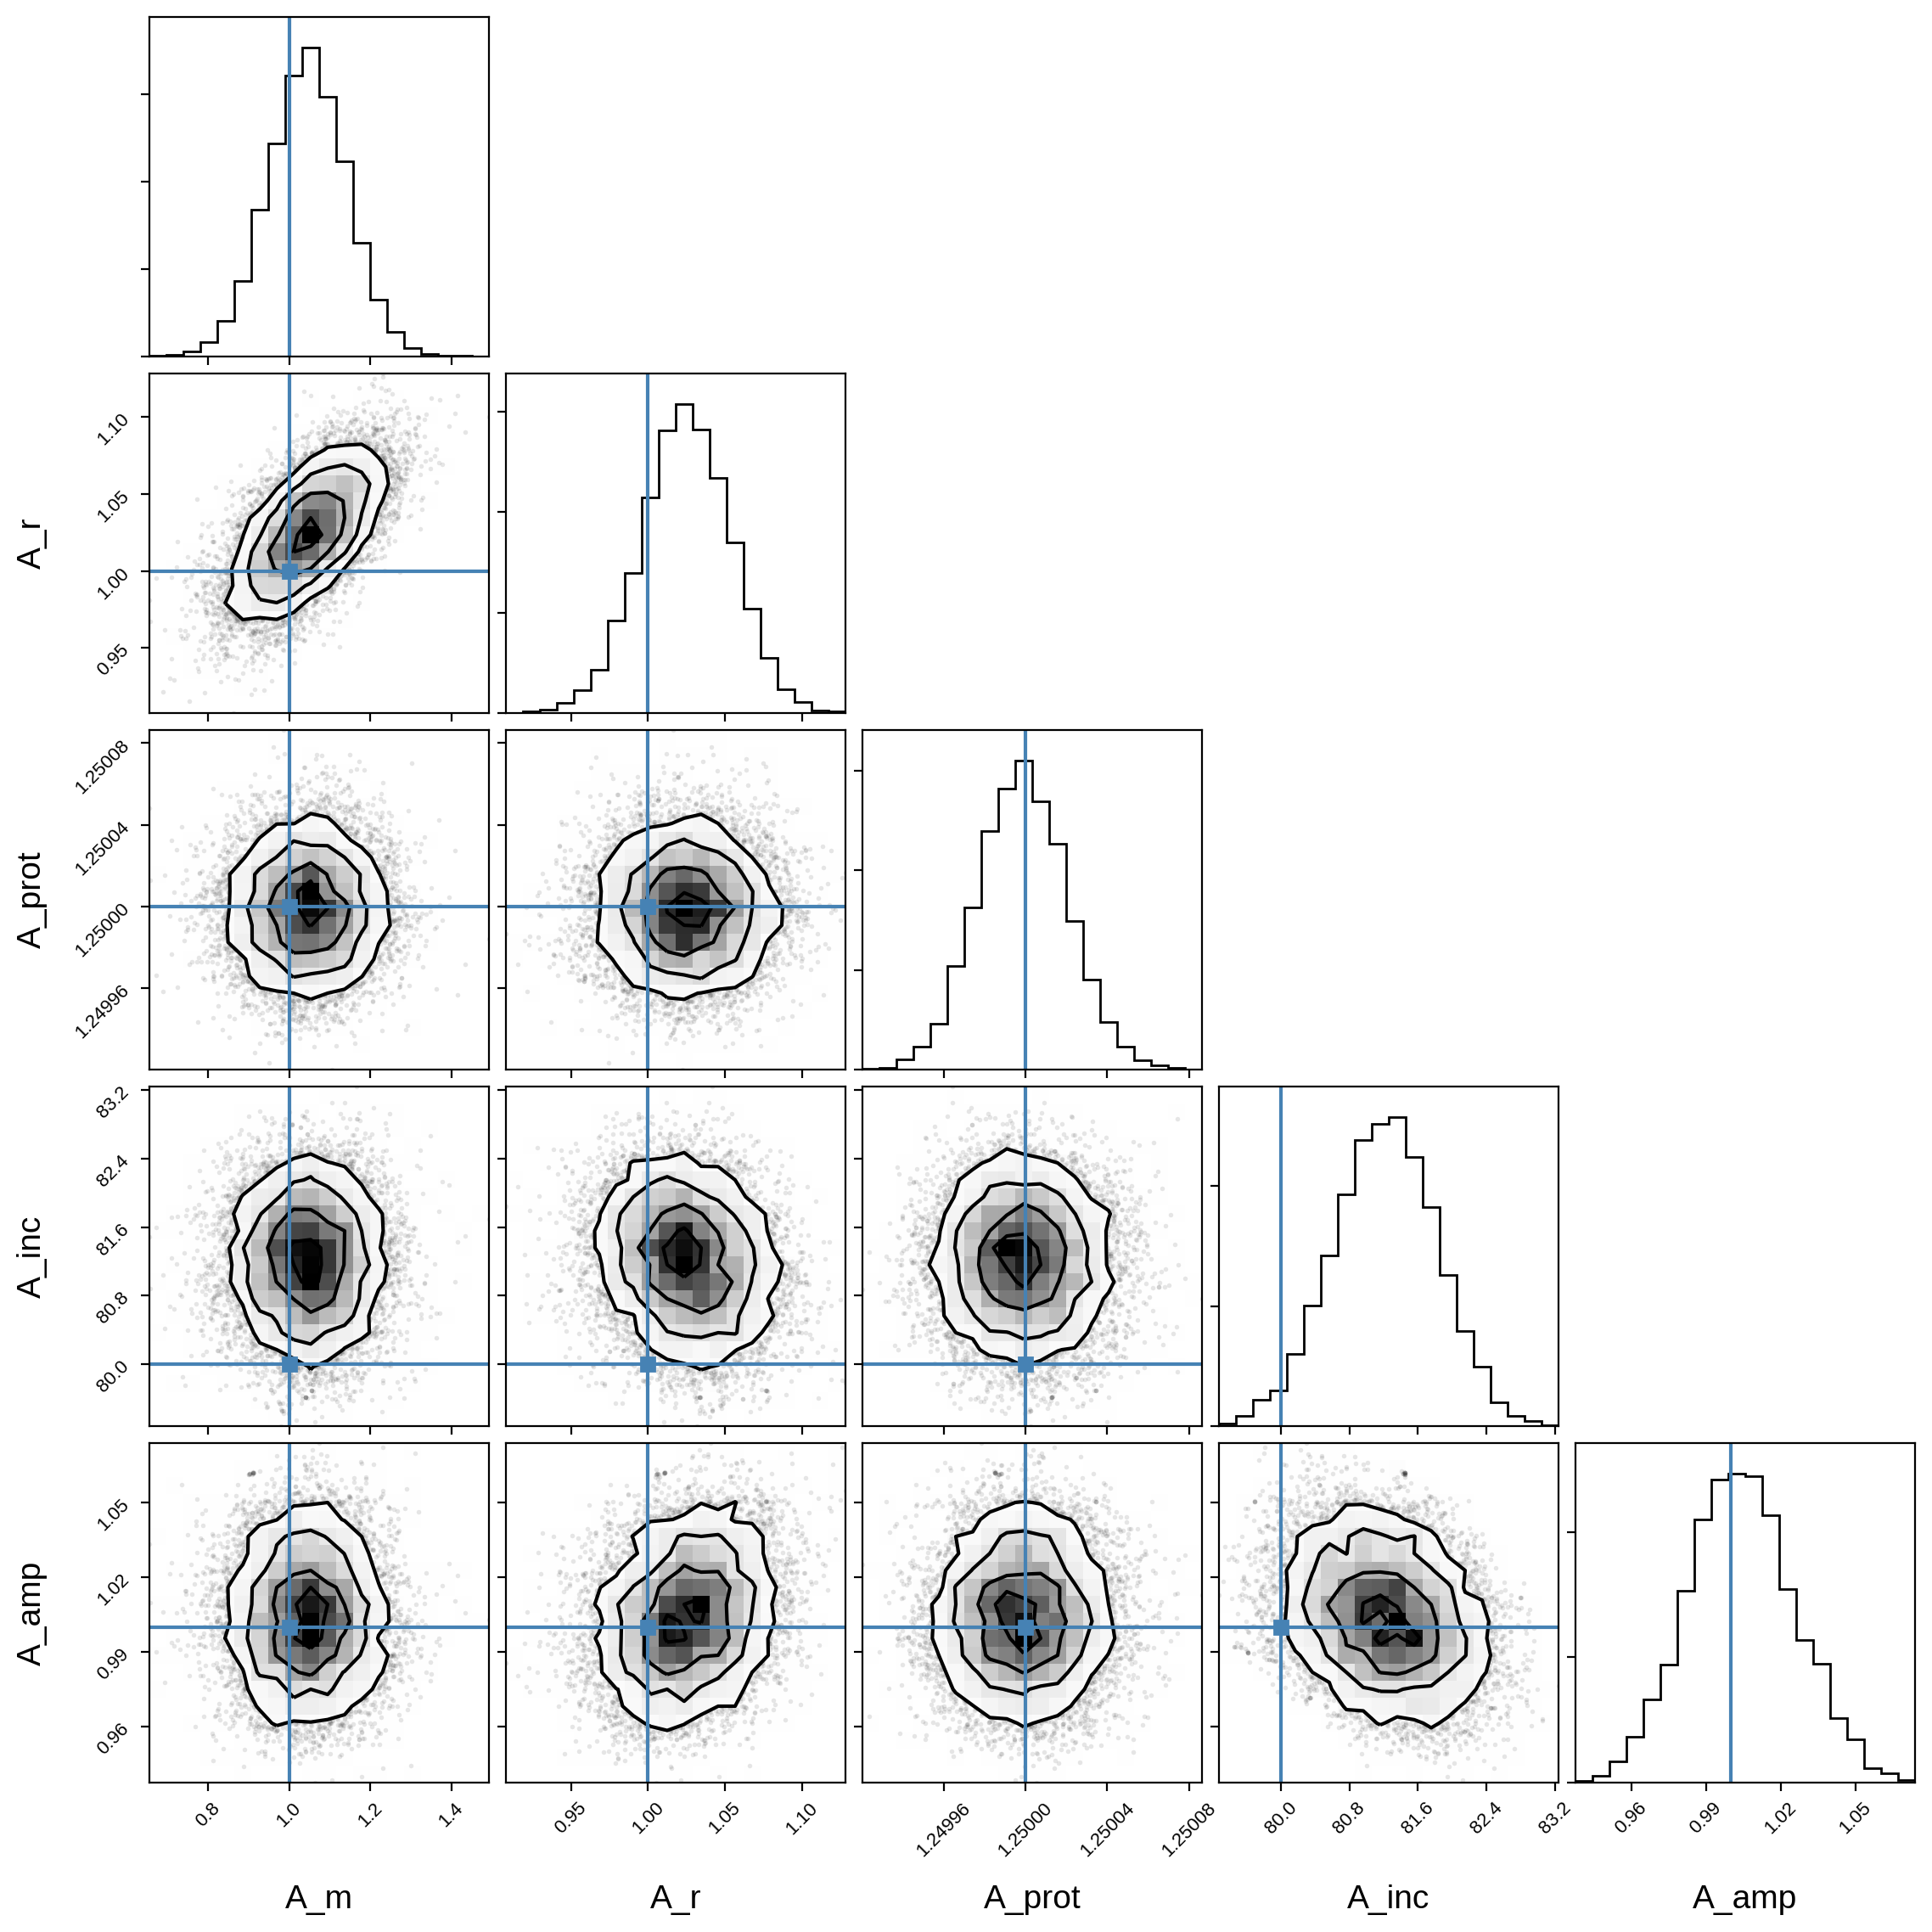

In [17]:
truths_A = [A["m"], A["r"], A["prot"], A["inc"], A["amp"]]
samples_A = pm.trace_to_dataframe(trace, varnames=var_names_A)
corner(samples_A, truths=truths_A);

And here's that same plot for the secondary orbital parameters:

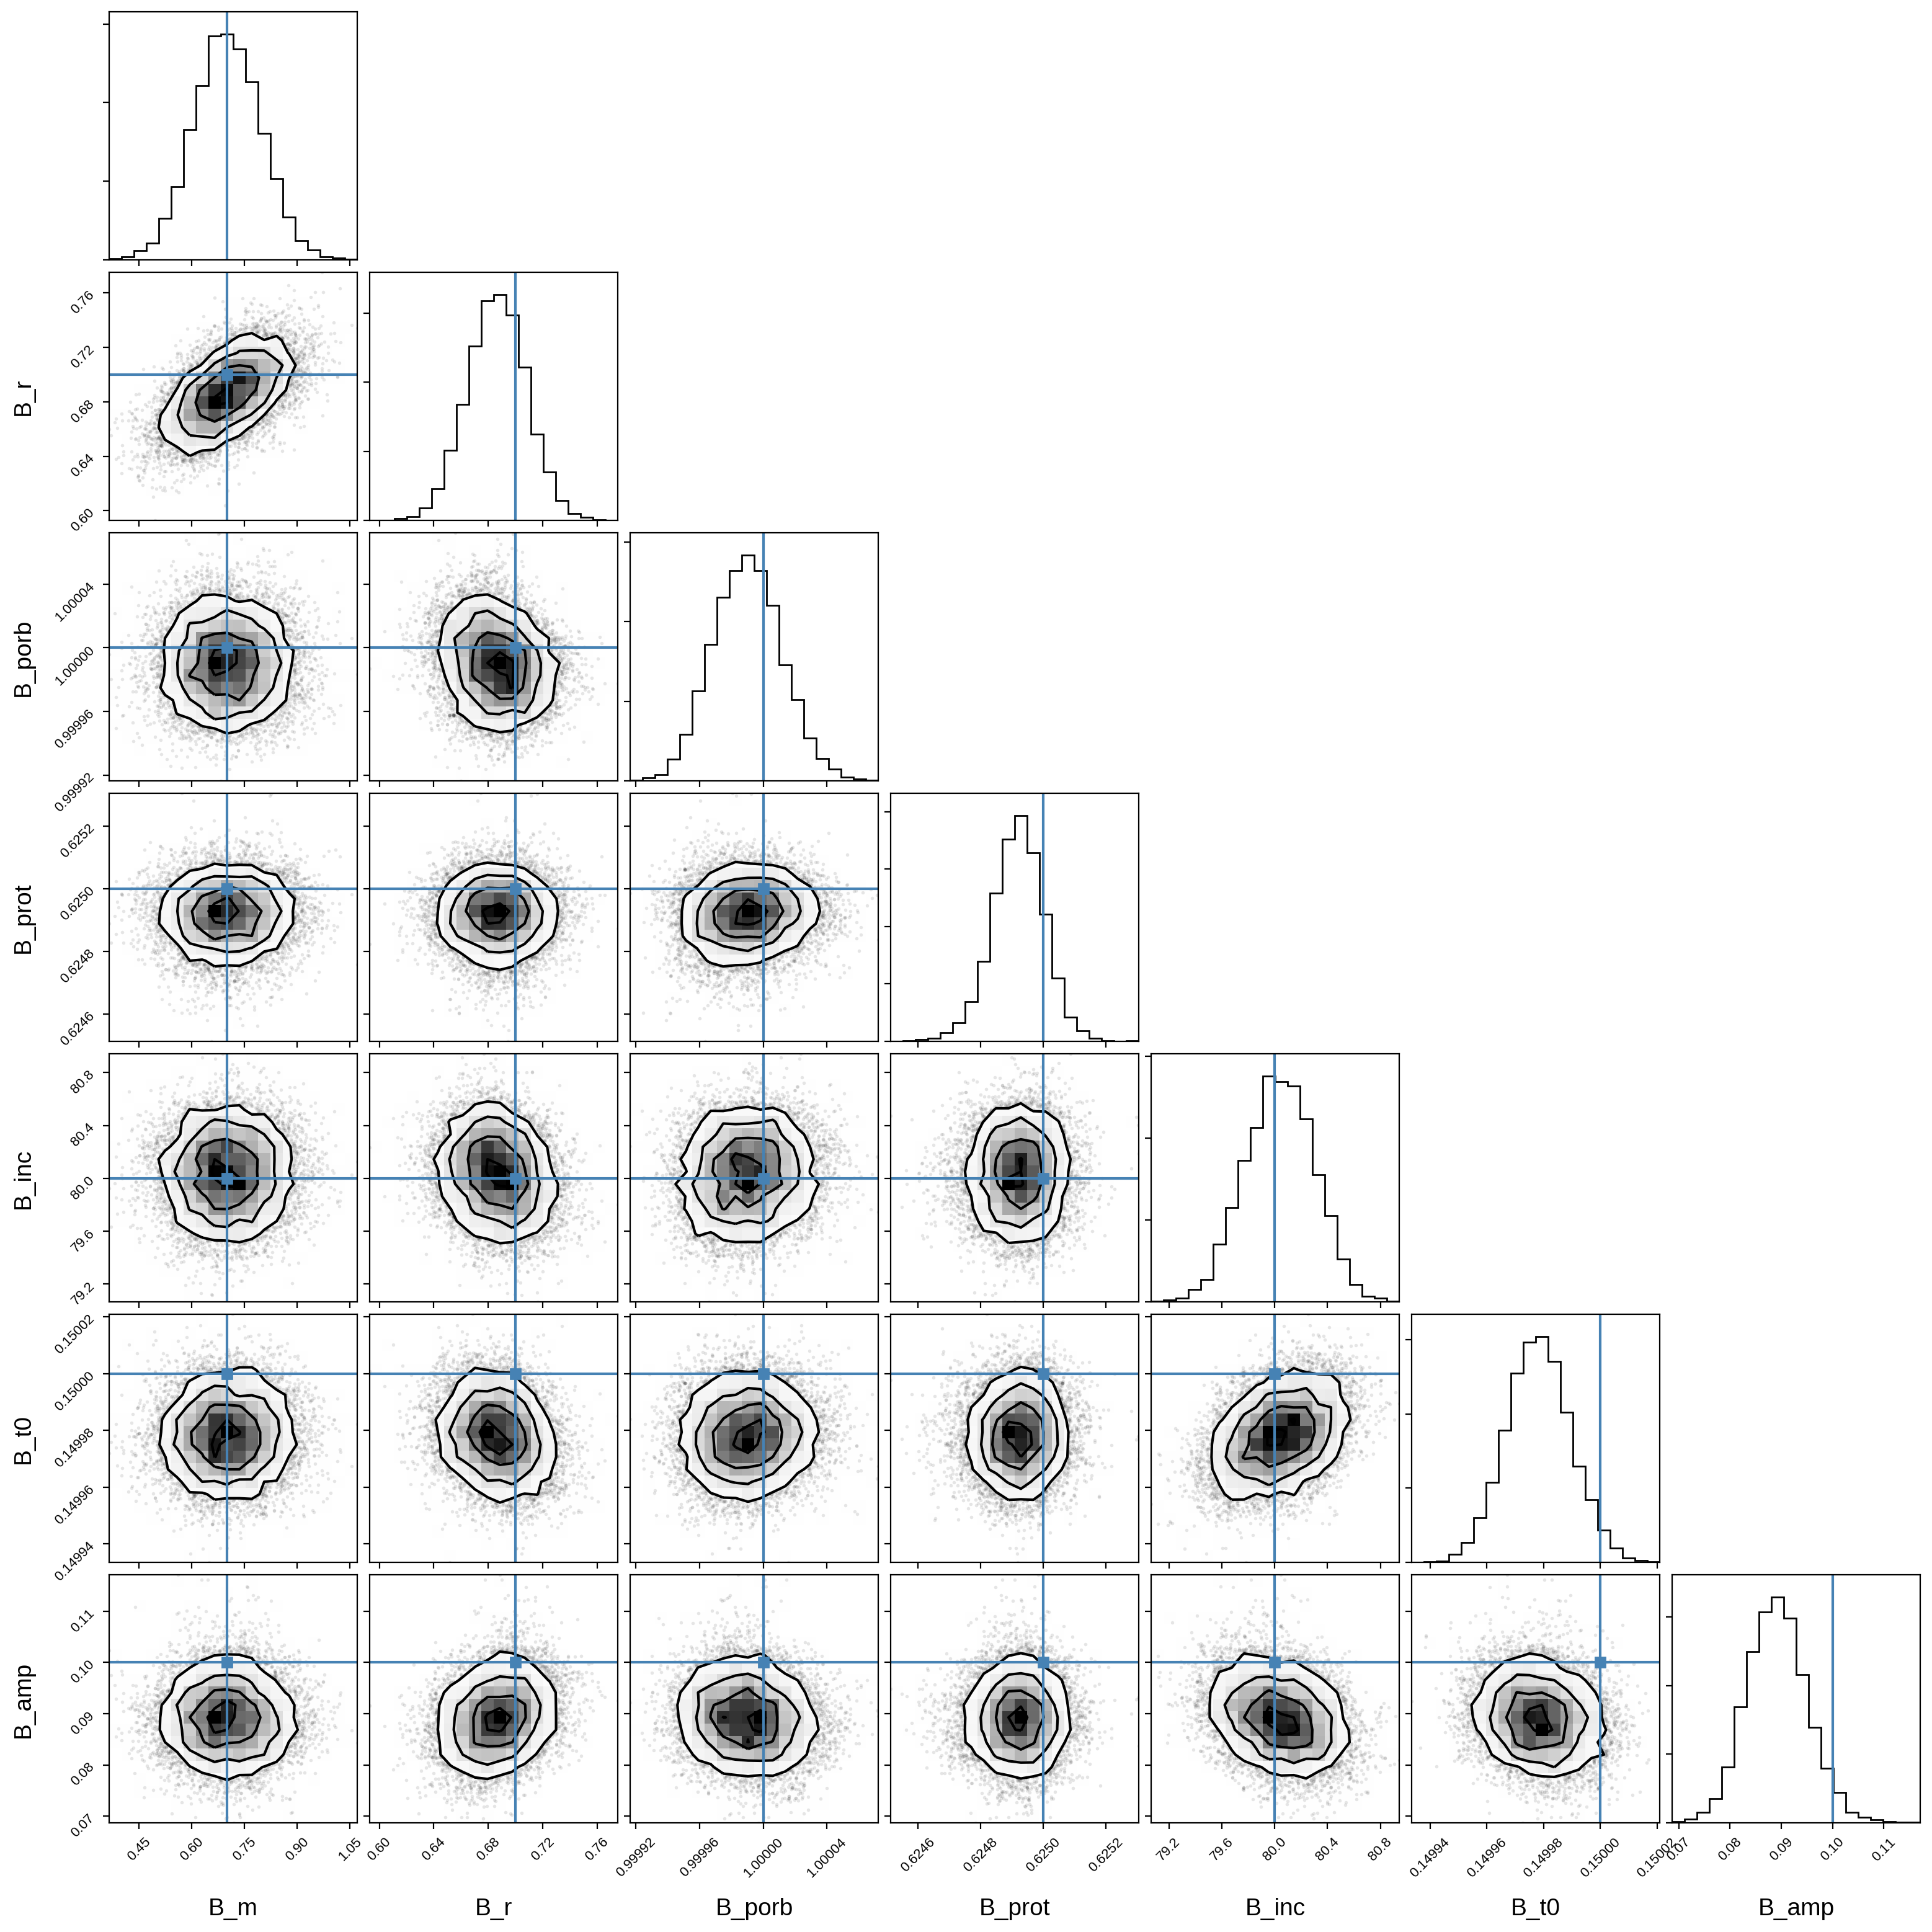

In [18]:
truths_B = [B["m"], B["r"], B["porb"], B["prot"], B["inc"], B["t0"], B["amp"]]
samples_B = pm.trace_to_dataframe(trace, varnames=var_names_B)
corner(samples_B, truths=truths_B);

Let's plot the model for 24 random samples from the chain. Note that the lines are so close together that they're indistinguishable!

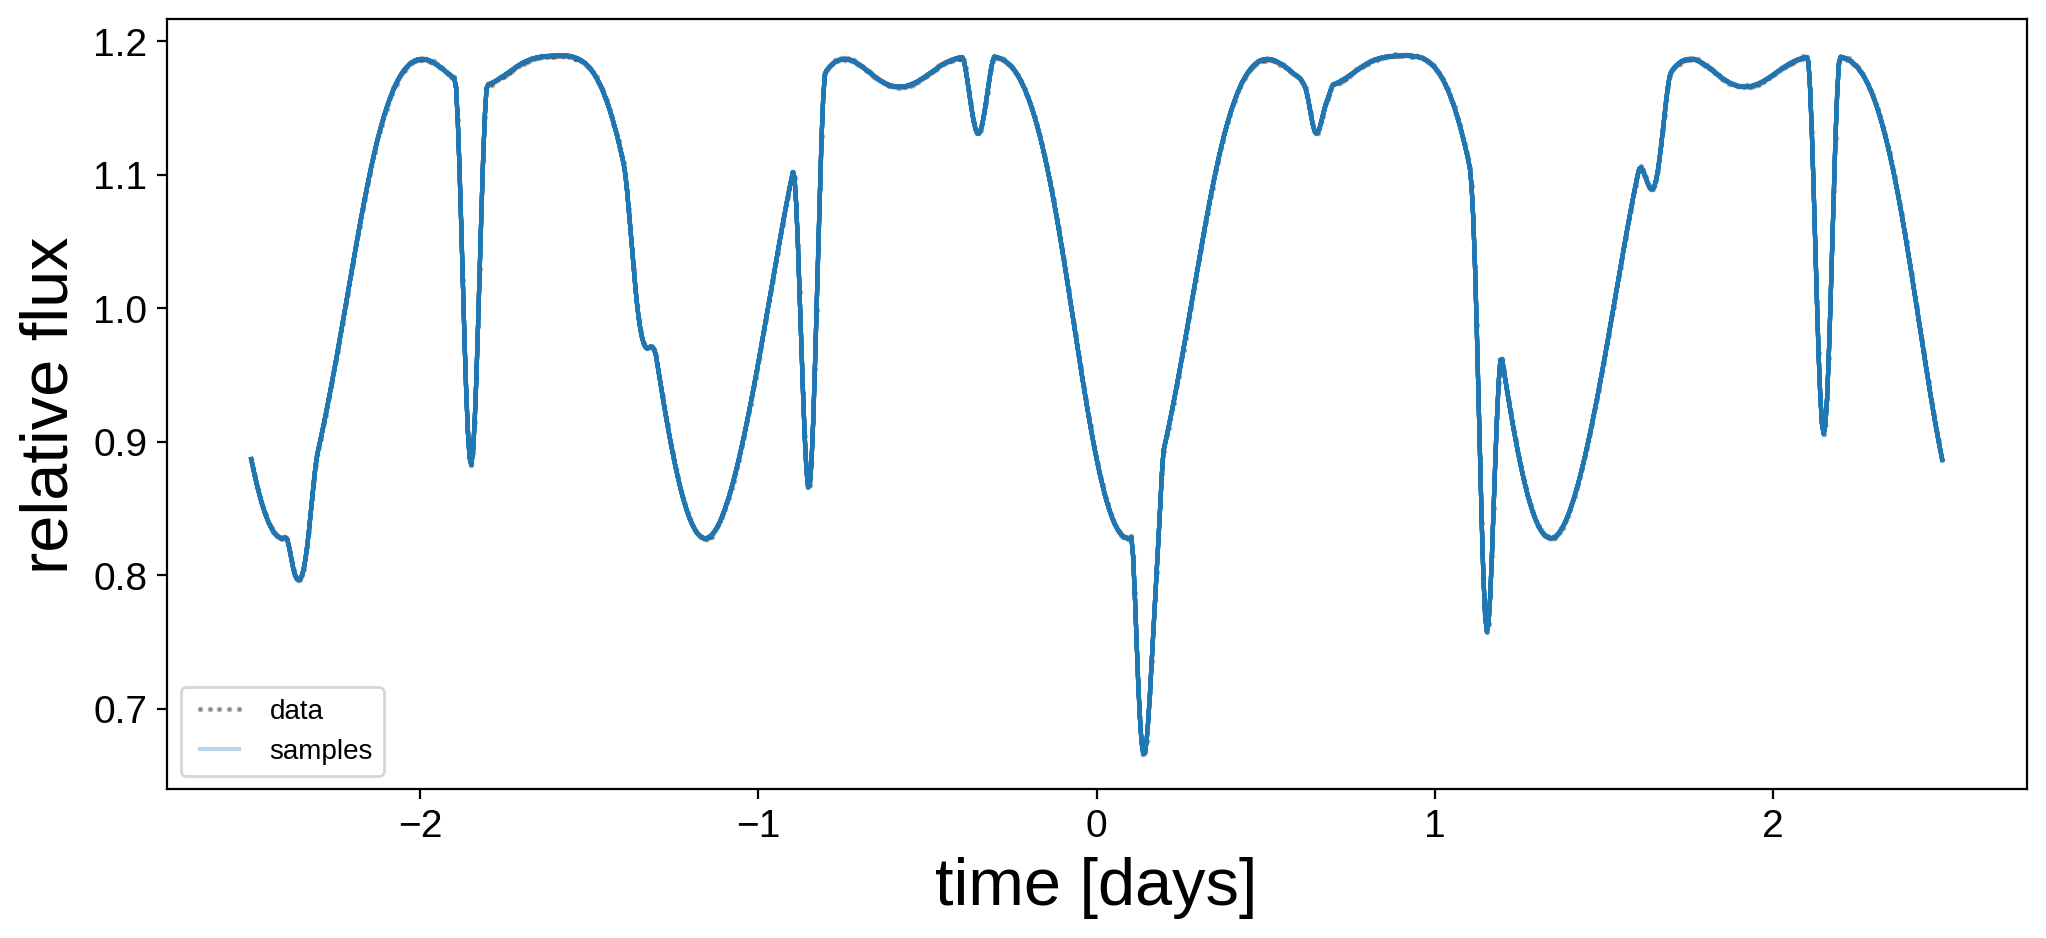

In [19]:
plt.figure(figsize=(12, 5))
plt.plot(t, flux, "k.", alpha=0.3, ms=2, label="data")
label = "samples"
for i in np.random.choice(range(len(trace["flux_model"])), 24):
    plt.plot(t, trace["flux_model"][i], "C0-", alpha=0.3, label=label)
    label = None
plt.legend(fontsize=10, numpoints=5)
plt.xlabel("time [days]", fontsize=24)
plt.ylabel("relative flux", fontsize=24);

Let's compare the *mean* map and a *random* sample to the true map for each star:

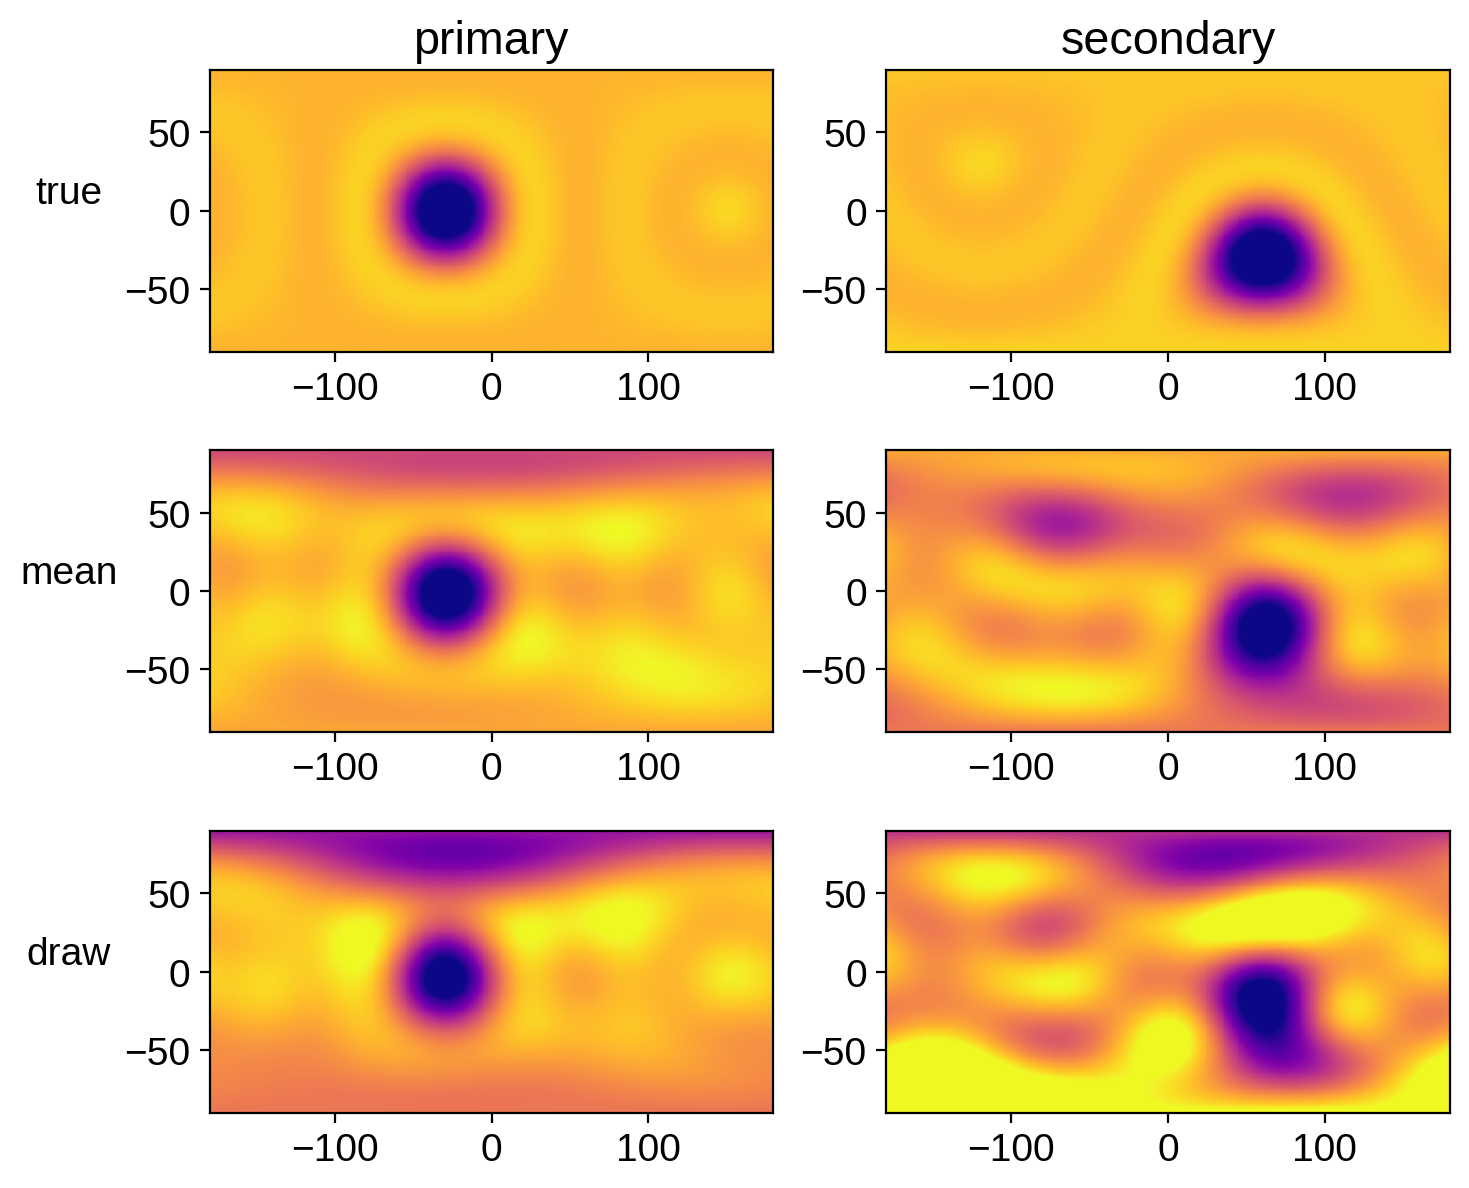

In [20]:
# Random sample
np.random.seed(0)
i = np.random.randint(len(trace["pri_y"]))

map = starry.Map(ydeg=A["ydeg"])
map.amp = np.mean(trace["A_amp"])
map[1:, :] = np.mean(trace["pri_y"], axis=0)
pri_mu = map.render(projection="rect").eval()
map.amp = trace["A_amp"][i]
map[1:, :] = trace["pri_y"][i]
pri_draw = map.render(projection="rect").eval()
map.amp = A["amp"]
map[1:, :] = A["y"]
pri_true = map.render(projection="rect").eval()

map = starry.Map(ydeg=B["ydeg"])
map.amp = np.mean(trace["B_amp"])
map[1:, :] = np.mean(trace["sec_y"], axis=0)
sec_mu = map.render(projection="rect").eval()
map.amp = trace["B_amp"][i]
map[1:, :] = trace["sec_y"][i]
sec_draw = map.render(projection="rect").eval()
map.amp = B["amp"]
map[1:, :] = B["y"]
sec_true = map.render(projection="rect").eval()

fig, ax = plt.subplots(3, 2, figsize=(8, 7))
ax[0, 0].imshow(
    pri_true,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[1, 0].imshow(
    pri_mu,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[2, 0].imshow(
    pri_draw,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[0, 1].imshow(
    sec_true,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.04,
)
ax[1, 1].imshow(
    sec_mu,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.04,
)
ax[2, 1].imshow(
    sec_draw,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.04,
)
ax[0, 0].set_title("primary")
ax[0, 1].set_title("secondary")
ax[0, 0].set_ylabel("true", rotation=0, labelpad=20)
ax[1, 0].set_ylabel("mean", rotation=0, labelpad=20)
ax[2, 0].set_ylabel("draw", rotation=0, labelpad=20);

That actually looks pretty good. But keep in mind that we really should have run our chain longer.

However, there is a **much better way** of doing what we did here. We can combine `pymc3` with the linearity of the `starry` model to come up with a **much more efficient** way of sampling the posterior. We do that in [the next and final notebook](EclipsingBinary_FullSolution.ipynb) of the series.